# Call Reports Analysis

##### Housekeeping and loading data

In [1]:
# Load packages
import os
import statsmodels.api as sm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
path = 'C:/Users/angel/Documents/Economics/Research/Banking Project/data/intermediate/call_reports_SP/'

# Set path to be the directory:
os.chdir(path)

In [3]:
# SAVE DATA IN A SINGLE .CSV FILE
#df = pd.concat([pd.read_csv(f) for f in os.listdir() if f.endswith('.csv')])

# check how many columns are in the data:
#n_col = df.shape[1]
#df = df.iloc[:, 0:n_col-2]

#df['Date'] = df['Date'].astype(str)
#df['Month'] = np.where(df['Date'].str.len() == 8, df['Date'].str[0:2], '0'+df['Date'].str[0])
#df['Day'] = df['Date'].str[-6:-4]
#df['Year'] = df['Date'].str[-4:]
#df['Date'] = pd.to_datetime(df['Year'] + '-' + df['Month'] + '-' + df['Day'])
#df.to_csv(path + 'call_reports.csv', index = False)

In [4]:
fed_funds = pd.read_csv('C:/Users/angel/Documents/Economics/Research/Banking Project/data/intermediate/FEDFUNDS.csv', parse_dates = ['DATE'])

# Rename 'DATE' to 'Date' in fed_funds:
fed_funds = fed_funds.rename(columns = {'DATE':'Date'})

# Divide FEDFUNDS by 100 to get the interest rate in percentage terms:
fed_funds['FEDFUNDS'] = fed_funds['FEDFUNDS']/100

In [5]:
# Make the dates in fed_funds to be the last day of the previous month:
fed_funds['Date'] = fed_funds['Date'] - pd.DateOffset(days = 1)

In [6]:
# Read file that contains only the variables of interest, specify that the column 'Date' is a date:
main = pd.read_csv('call_reports.csv', parse_dates = ['Date'])

C:\Users\angel\AppData\Local\Temp\ipykernel_22500\914245168.py:2: DtypeWarning: Columns (102,146,187,270,293) have mixed types. Specify dtype option on import or set low_memory=False.
  main = pd.read_csv('call_reports.csv', parse_dates = ['Date'])


In [7]:
# drop all columns in main that start with 'Unnamed':
main = main.loc[:, ~main.columns.str.contains('^Unnamed')]

In [8]:
# merge the data:
main  = pd.merge(main, fed_funds, how = 'left', on = 'Date').sort_values(by = ['IDRSSD', 'Date'])

In [9]:
balanced_panel = 1

if balanced_panel == 1:

    # Step 1: Count the total number of unique dates in the dataset
    total_dates = main['Date'].nunique()
    print('Number of dates:', total_dates)

    # Step 2: Count the number of unique dates each bank shows up
    bank_date_counts = main.groupby('IDRSSD')['Date'].nunique()
    print('Banks that show up in all dates:', sum(bank_date_counts==total_dates))

    # Step 3: Identify banks that are present in all dates
    balanced_banks = bank_date_counts[bank_date_counts == total_dates].index

    # Step 4: Filter the dataset to create a balanced panel with only these banks
    balanced_panel = main[main['IDRSSD'].isin(balanced_banks)]

    main = balanced_panel

Number of dates: 93
Banks that show up in all dates: 3747


## Deposits

##### Basic Definitions

In [10]:
# Create a new column that will contain the deposit expenditure it will sum 'RIADA517', 'RIADA518', 'RIAD4508', 'RIAD0093' for
# any date before 2017:
main['Deposit Expenditure'] = np.where(main['Date'] < '2017-01-01', main['RIADA517']+main['RIADA518']+main['RIAD4508']+main['RIAD0093'], 
                            main['RIADHK03']+main['RIADHK04']+main['RIAD4508']+main['RIAD0093'])

# Group by 'ID' and compute the difference in 'Deposit_Expenditure' to get the actual expenditure per period
main['Actual Expenditure'] = main.groupby(['IDRSSD', 'Year'])['Deposit Expenditure'].diff().fillna(main['Deposit Expenditure'])

main['Total Deposit'] = np.where(main['Date'] < '2017-01-01', main['RCON3485']+main['RCONB563']+main['RCONA514']+main['RCONA529'], 
                                     main['RCON3485']+main['RCONB563']+main['RCONHK16']+main['RCONHK17'])

# get the variation in deposits per period:
main['Deposit Variation'] = main.groupby(['IDRSSD'])['Total Deposit'].diff()

# Compute the Aggregate Deposits as the sum of all deposits in a given date:
main['Aggregate Deposits'] = main.groupby('Date')['Total Deposit'].transform('sum')

# get the variation of 'Aggregate Deposits':
main['Aggregate Deposits Variation'] = main.groupby('IDRSSD')['Aggregate Deposits'].diff()
main['Pct. Aggregate Deposits Variation'] = main.groupby('IDRSSD')['Aggregate Deposits'].pct_change()

# compute the share of deposits of a given bank in the total deposits of all banks in a given date:
main['Deposit Share'] = main['Total Deposit']/main.groupby('Date')['Total Deposit'].transform('sum')

# Calculate s_{it} - s_{it-1} (Deposit Share Variation)
main['Deposit Share Variation'] = main.groupby('IDRSSD')['Deposit Share'].diff()

In [11]:
# Compute deposit rates:
main = main[main['Total Deposit']>0]
main['Deposit Rate'] = main['Actual Expenditure'] / main['Total Deposit']

# Average the deposit rate by 'Date', weighting by 'Total Deposit':
main['Weighted Deposit Rate'] = main.groupby('Date')['Deposit Rate'].transform(lambda x: np.average(x, weights = main.loc[x.index, 'Total Deposit']))

C:\Users\angel\AppData\Local\Temp\ipykernel_22500\2058518839.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main['Deposit Rate'] = main['Actual Expenditure'] / main['Total Deposit']
C:\Users\angel\AppData\Local\Temp\ipykernel_22500\2058518839.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main['Weighted Deposit Rate'] = main.groupby('Date')['Deposit Rate'].transform(lambda x: np.average(x, weights = main.loc[x.index, 'Total Deposit']))


In [12]:
# Create an extra column in df3 with the avg. deposit rate per Date:
main['Avg. Deposit Rate'] = main.groupby('Date')['Deposit Rate'].transform('mean')
main['Std. Deposit Rate'] = main.groupby('Date')['Deposit Rate'].transform('std')
main['R_hat'] = (main['Deposit Rate'] - main['Avg. Deposit Rate']) #/ main['Std. Deposit Rate']

C:\Users\angel\AppData\Local\Temp\ipykernel_22500\1105997460.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main['Avg. Deposit Rate'] = main.groupby('Date')['Deposit Rate'].transform('mean')
C:\Users\angel\AppData\Local\Temp\ipykernel_22500\1105997460.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main['Std. Deposit Rate'] = main.groupby('Date')['Deposit Rate'].transform('std')
C:\Users\angel\AppData\Local\Temp\ipykernel_22500\1105997460.py:4: SettingWithCopyWarning: 
A value is trying to be set o

In [13]:
df = main[[   'IDRSSD', 'Date',                                           # IDRSSD and Date 
            'Total Deposit', 'Deposit Share', 'Deposit Variation',      # Bank specific qunatity variables
            'Deposit Rate', 'R_hat',                                    # Bank specific rate variable
            'Aggregate Deposits', 'Aggregate Deposits Variation',       # Aggregate quantity variables 
            'FEDFUNDS', 'Weighted Deposit Rate'                         # Aggregate rate variables
            ]]

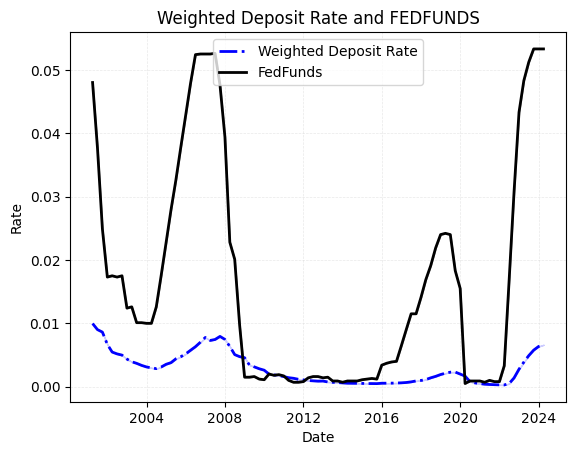

In [14]:
# plot the time series of 'Weighted Deposit Rate' and 'FEDFUNDS':
sns.lineplot(data = df, x = 'Date', y = 'Weighted Deposit Rate', 
             label = 'Weighted Deposit Rate', color = 'blue', linewidth = 2, linestyle = '-.')
sns.lineplot(data = df, x = 'Date', y = 'FEDFUNDS', 
             label = 'FedFunds', color = 'black', linestyle = '-', linewidth = 2)
plt.xlabel('Date')
plt.ylabel('Rate')
plt.title('Weighted Deposit Rate and FEDFUNDS')
plt.grid(color = 'lightgray', linestyle = '--', linewidth = 0.5, alpha = 0.5)
plt.legend(loc='upper center')
plt.show()

In [15]:
# Until here, dataset matches with Lucas.
#df2[(df2['Date']>'2023-01-01') & (df2['Date']<'2024-01-01')]['Deposit Rate'].describe()

##### Distribution of deposit rates

In [16]:
df_bottom = df.groupby('Date').apply(lambda x: x[(x['Total Deposit'] >= x['Total Deposit'].quantile(0.05))&
                                                 (x['Total Deposit'] <= x['Total Deposit'].quantile(0.95))]).reset_index(drop=True)
df_top = df.groupby('Date').apply(lambda x: x[x['Total Deposit'] >= x['Total Deposit'].quantile(0.95)]).reset_index(drop=True)


C:\Users\angel\AppData\Local\Temp\ipykernel_22500\3785463281.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_bottom = df.groupby('Date').apply(lambda x: x[(x['Total Deposit'] >= x['Total Deposit'].quantile(0.05))&
C:\Users\angel\AppData\Local\Temp\ipykernel_22500\3785463281.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_top = df.groupby('Date').apply(lambda x: x[x['Total Deposit'] >= x['Total

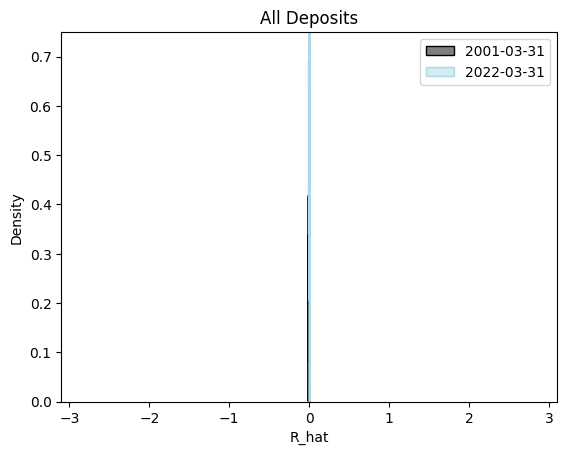

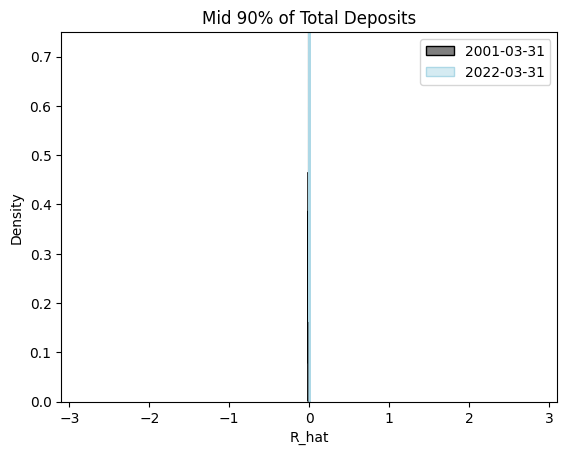

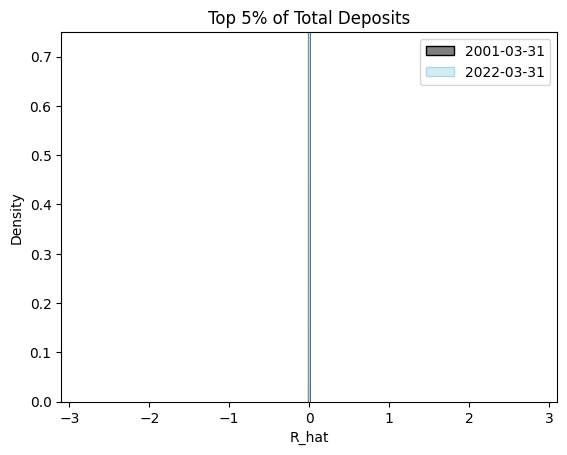

In [17]:
# plot the kernel distribution of the deposit rates for the above dates:
sns.kdeplot(df[df['Date']=='2001-03-31']['R_hat'], label='2001-03-31', color='black', fill=True, alpha=0.5)
sns.kdeplot(df[df['Date']=='2022-03-31']['R_hat'], label='2022-03-31', color='lightblue', fill=True, alpha=0.5)
plt.xlim(-3.1, 3.1)
plt.ylim(0, 0.75)
plt.legend()
plt.title('All Deposits')
plt.show()

# plot the kernel distribution of the deposit rates for the above dates:
sns.kdeplot(df_bottom[df_bottom['Date']=='2001-03-31']['R_hat'], label='2001-03-31', color='black', fill=True, alpha=0.5)
sns.kdeplot(df_bottom[df_bottom['Date']=='2022-03-31']['R_hat'], label='2022-03-31', color='lightblue', fill=True, alpha=0.5)
#Adjust the x-axis to be able to see the distribution better:
plt.xlim(-3.1, 3.1)
plt.ylim(0, 0.75)
plt.legend()
plt.title('Mid 90% of Total Deposits')
plt.show()



# plot the kernel distribution of the deposit rates for the above dates:
sns.kdeplot(df_top[df_top['Date']=='2001-03-31']['R_hat'], label='2001-03-31', color='black', fill=True, alpha=0.5)
sns.kdeplot(df_top[df_top['Date']=='2022-03-31']['R_hat'], label='2022-03-31', color='lightblue', fill=True, alpha=0.5)
plt.xlim(-3.1, 3.1)
plt.ylim(0, 0.75)
plt.legend()
plt.title('Top 5% of Total Deposits')
plt.show()

##### What type of funding banks use?

In [18]:
# Rename RCONB563 as 'Savings Accounts':
main.rename(columns = {'RCONB563':'Savings Accounts', 'RCON3485': 'Transaction Accounts'}, inplace = True)

C:\Users\angel\AppData\Local\Temp\ipykernel_22500\3042373835.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main.rename(columns = {'RCONB563':'Savings Accounts', 'RCON3485': 'Transaction Accounts'}, inplace = True)


In [19]:
main['Small TD'] = np.where(main['Date'] < '2017-01-01', main['RCONA529'], main['RCONHK16']) 
main['Small TD Exp'] = np.where(main['Date'] < '2017-01-01', main['RIADA518'], main['RIADHK03'])
main['Large TD'] = np.where(main['Date'] < '2017-01-01', main['RCONA514'], main['RCONHK17']) 
main['Large TD Exp'] = np.where(main['Date'] < '2017-01-01', main['RIADA517'], main['RIADHK04'])

C:\Users\angel\AppData\Local\Temp\ipykernel_22500\3270645210.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main['Small TD'] = np.where(main['Date'] < '2017-01-01', main['RCONA529'], main['RCONHK16'])
C:\Users\angel\AppData\Local\Temp\ipykernel_22500\3270645210.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main['Small TD Exp'] = np.where(main['Date'] < '2017-01-01', main['RIADA518'], main['RIADHK03'])
C:\Users\angel\AppData\Local\Temp\ipykernel_22500\3270645210.py:3: SettingWithCopyWarning: 
A va

In [20]:
main['Actual Small TD Exp'] = main.groupby(['IDRSSD', 'Year'])['Small TD Exp'].diff().fillna(main['Small TD Exp'])
main['Actual Large TD Exp'] = main.groupby(['IDRSSD', 'Year'])['Large TD Exp'].diff().fillna(main['Large TD Exp'])

C:\Users\angel\AppData\Local\Temp\ipykernel_22500\650303768.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main['Actual Small TD Exp'] = main.groupby(['IDRSSD', 'Year'])['Small TD Exp'].diff().fillna(main['Small TD Exp'])
C:\Users\angel\AppData\Local\Temp\ipykernel_22500\650303768.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main['Actual Large TD Exp'] = main.groupby(['IDRSSD', 'Year'])['Large TD Exp'].diff().fillna(main['Large TD Exp'])


In [21]:
main['Savings Rate'] = main.groupby(['IDRSSD', 'Year'])['RIAD0093'].diff().fillna(main['RIAD0093']) / main['Savings Accounts']
main['Large TD Rate'] = main['Actual Large TD Exp'] / main['Large TD']
main['Small TD Rate'] =   main['Actual Small TD Exp'] / main['Small TD']

C:\Users\angel\AppData\Local\Temp\ipykernel_22500\1590962670.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main['Savings Rate'] = main.groupby(['IDRSSD', 'Year'])['RIAD0093'].diff().fillna(main['RIAD0093']) / main['Savings Accounts']
C:\Users\angel\AppData\Local\Temp\ipykernel_22500\1590962670.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main['Large TD Rate'] = main['Actual Large TD Exp'] / main['Large TD']
C:\Users\angel\AppData\Local\Temp\ipykernel_22500\1590962670.py:3: SettingWithCopyWarnin

In [22]:
# Create a new column that contains the share of each type of deposit in the total deposits, per year, per bank:
main['Small TD Share'] = main['Small TD'] / main['Total Deposit']
main['Large TD Share'] = main['Large TD'] / main['Total Deposit']
main['Savings Share'] = main['Savings Accounts'] / main['Total Deposit']
main['Transaction Share'] = main['Transaction Accounts'] / main['Total Deposit']


C:\Users\angel\AppData\Local\Temp\ipykernel_22500\1767572871.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main['Small TD Share'] = main['Small TD'] / main['Total Deposit']
C:\Users\angel\AppData\Local\Temp\ipykernel_22500\1767572871.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main['Large TD Share'] = main['Large TD'] / main['Total Deposit']
C:\Users\angel\AppData\Local\Temp\ipykernel_22500\1767572871.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

In [23]:
df = main[[ 'IDRSSD', 'Date', 'Financial Institution Name',                           # Dates and IDS 
            'Total Deposit', 'Small TD', 'Large TD', 
            'Savings Accounts', 'Transaction Accounts',                               # Deposit type variables
            'Deposit Share', 'Deposit Variation',                                     # Bank specific quantity variables
            'Small TD Share', 'Large TD Share', 'Savings Share', 'Transaction Share', # Deposit type shares
            'Deposit Rate', 'R_hat',                                                  # Bank specific rate variable
            'Savings Rate', 'Large TD Rate', 'Small TD Rate',                         # Deposit type rates
            'Aggregate Deposits', 'Aggregate Deposits Variation',                     # Aggregate quantity variables 
            'FEDFUNDS', 'Weighted Deposit Rate'                                       # Aggregate rate variables
            ]]

In [24]:
# take the top 10 banks in 'Total Deposit' in the most recent date, and plot their deposit rates:
top_10_today = df[df['Date'] == df['Date'].max()].nlargest(10, 'Total Deposit')['Financial Institution Name']

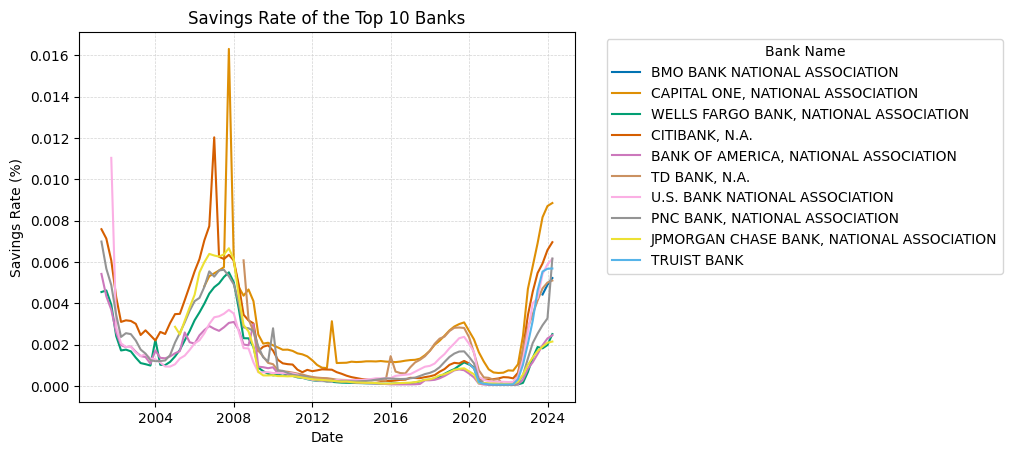

In [25]:
# use 'bank_data' to plot the time series of savings rates, dont use red or green colors:
sns.lineplot(data = df[df['Financial Institution Name'].isin(top_10_today)], x = 'Date', y = 'Savings Rate', hue = 'Financial Institution Name', palette = 'colorblind')
plt.xlabel('Date')
plt.ylabel('Savings Rate (%)')
plt.title('Savings Rate of the Top 10 Banks')
plt.legend(title = 'Bank Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(color = 'lightgray', linestyle = '--', linewidth = 0.5)
plt.show()

In [26]:
# make a dataset that has only the top 10 banks in 'Total Deposit' per year:
df_top10 = df.groupby(['Date']).apply(lambda x: x.nlargest(10, 'Total Deposit')).reset_index(drop=True)

# compute the share of each bank in the total deposits of the top 10 banks per year:
df_top10['Share in Top 10'] = df_top10['Total Deposit'] / df_top10.groupby('Date')['Total Deposit'].transform('sum')

C:\Users\angel\AppData\Local\Temp\ipykernel_22500\527871687.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_top10 = df.groupby(['Date']).apply(lambda x: x.nlargest(10, 'Total Deposit')).reset_index(drop=True)


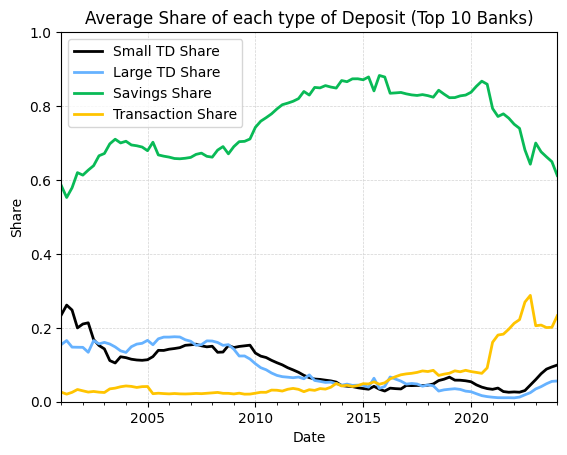

In [27]:
# Group by 'Date' and sum the weighted shares:
df_top10_unweighted_shares = df_top10.groupby('Date')[['Small TD Share', 'Large TD Share', 
                                    'Savings Share', 'Transaction Share']].mean().reset_index()

# plot the weighted average share of each type of deposit for the top 10 banks:
df_top10_unweighted_shares.set_index('Date').plot(markersize=2, linewidth=2, 
                                color=['black', '#66B2FF', '#09BA56', '#FFC400'])
plt.xlabel('Date')
plt.ylabel('Share')
plt.ylim(0, 1)
plt.title('Average Share of each type of Deposit (Top 10 Banks)')
plt.grid(color = 'lightgray', linestyle = '--', linewidth = 0.5)
plt.show()


In [28]:
df_top10_unweighted = df_top10.groupby('Date')[['Small TD', 'Large TD', 
                                    'Savings Accounts', 'Transaction Accounts']].mean().reset_index()

# make the stacked barplot as in the cell below, but divide deposits by 1e6:
df_top10_unweighted[['Small TD', 'Large TD', 'Savings Accounts', 'Transaction Accounts']] = df_top10_unweighted[['Small TD', 'Large TD', 'Savings Accounts', 'Transaction Accounts']]/1e6

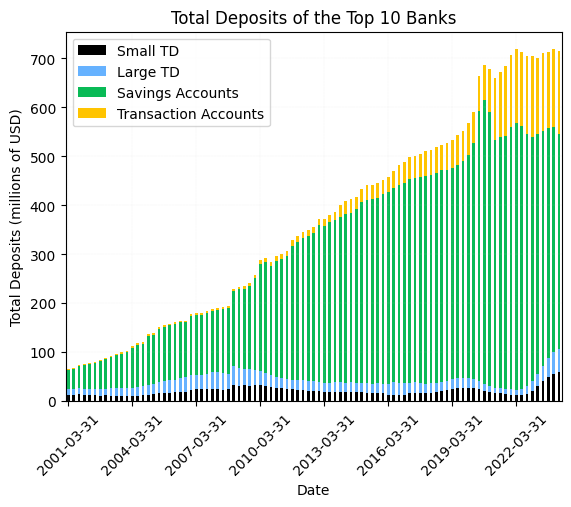

In [29]:
# make a stacked bar plot of the total deposits of the top 10 banks:
df_top10_unweighted.set_index('Date').plot(kind='bar', stacked=True, color=['black', '#66B2FF', '#09BA56', '#FFC400'])
# divide the values in the y-axis by 1e6 to make the numbers more readable:
# add just some ticks in the x-axis in the format 'YYYY-MM-DD':
plt.xticks(np.arange(0, len(df_top10_unweighted), 12), df_top10_unweighted['Date'].dt.strftime('%Y-%m-%d')[::12], rotation=45)
plt.xlabel('Date')
plt.ylabel('Total Deposits (millions of USD)')
plt.title('Total Deposits of the Top 10 Banks')
plt.grid(color = 'lightgray', linestyle = '--', linewidth = 0.1)
plt.show()

In [30]:
# compute the weighted average of the share of each type of deposit for the top 10 banks, weighted by 'Share in Top 10':
df_top10['Weighted Small TD Share'] = df_top10['Small TD Share'] * df_top10['Share in Top 10']
df_top10['Weighted Large TD Share'] = df_top10['Large TD Share'] * df_top10['Share in Top 10']
df_top10['Weighted Savings Share'] = df_top10['Savings Share'] * df_top10['Share in Top 10']
df_top10['Weighted Transaction Share'] = df_top10['Transaction Share'] * df_top10['Share in Top 10']

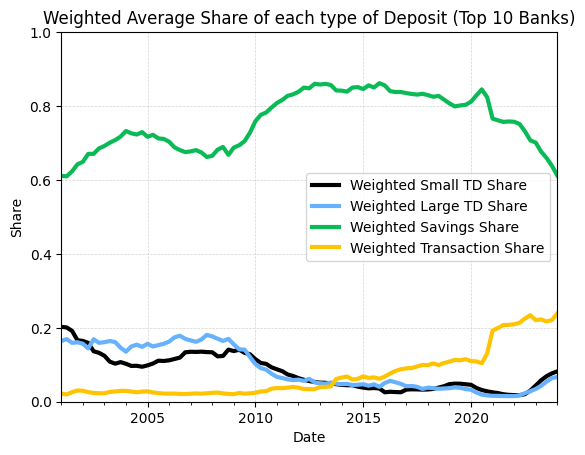

In [31]:
# Group by 'Date' and sum the weighted shares:
df_top10_weighted = df_top10.groupby('Date')[['Weighted Small TD Share', 'Weighted Large TD Share', 
                                    'Weighted Savings Share', 'Weighted Transaction Share']].sum().reset_index()

# plot the weighted average share of each type of deposit for the top 10 banks:
df_top10_weighted.set_index('Date').plot(markersize=2, linewidth=3, 
                                color=['black', '#66B2FF', '#09BA56', '#FFC400'])
plt.xlabel('Date')
plt.ylabel('Share')
plt.ylim(0, 1)
plt.title('Weighted Average Share of each type of Deposit (Top 10 Banks)')
plt.grid(color = 'lightgray', linestyle = '--', linewidth = 0.5)
plt.show()

In [32]:
# Do the same for the bottom 80 percentile of banks in 'Total Deposit', use the 'quantile' method to get the 80th percentile:
#df_bottom80 = df.groupby(['Date']).apply(lambda x: x[x['Total Deposit'] <= x['Total Deposit'].quantile(0.80)]).reset_index(drop=True)


In [33]:
# for each year, plot the average share of each type of deposit:
#df_bottom80[['Date', 'Small TD Share', 'Large TD Share', 'Savings Share', 'Transaction Share']].groupby('Date').mean().plot(linewidth=2)
#plt.xlabel('Date')
#plt.ylabel('Share')
#plt.ylim(0, 1)
#plt.title('Average Share of each type of Deposit (Bottom 80% of Banks)')
#plt.legend(title='Deposit Type')
#plt.grid(color = 'lightgray', linestyle = '--', linewidth = 0.5)
#plt.show()

##### Where does this dispersion is coming from?

In [34]:
# Create an extra column in df3 with the avg. deposit rate per Date:
df2 = df[(df['Savings Accounts']>0) & (df['Small TD']>0) & (df['Large TD']>0)].copy()

df2['Avg. Savings Rate'] = df2.groupby('Date')['Savings Rate'].transform('mean')
df2['Std. Savings Rate'] = df2.groupby('Date')['Savings Rate'].transform('std')
df2['Savings_hat'] = (df2['Savings Rate'] - df2['Avg. Savings Rate']) / df2['Std. Savings Rate']

In [35]:
df3 = df[(df['Savings Accounts']>0) & (df['Small TD']>0) & (df['Large TD']>0)].copy()
df3 = df3.groupby('Date').apply(lambda x: x[(x['Small TD'] >= x['Small TD'].quantile(0.01)) & (x['Small TD'] <= x['Small TD'].quantile(0.99))]).reset_index(drop=True)

df3['Avg. Small TD Rate'] = df3.groupby('Date')['Small TD Rate'].transform('mean')
df3['Std. Small TD Rate'] = df3.groupby('Date')['Small TD Rate'].transform('std')
df3['Small_TD_hat'] = (df3['Small TD Rate'] - df3['Avg. Small TD Rate']) / df3['Std. Small TD Rate']

C:\Users\angel\AppData\Local\Temp\ipykernel_22500\1251671019.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df3 = df3.groupby('Date').apply(lambda x: x[(x['Small TD'] >= x['Small TD'].quantile(0.01)) & (x['Small TD'] <= x['Small TD'].quantile(0.99))]).reset_index(drop=True)


In [36]:
df2_bottom = df2.groupby('Date').apply(lambda x: x[(x['Total Deposit'] >= x['Total Deposit'].quantile(0.05)) &
                                                 (x['Total Deposit'] <= 
                                                  x['Total Deposit'].quantile(0.95))]).reset_index(drop=True)
df2_top = df2.groupby('Date').apply(lambda x: x[x['Total Deposit'] >=
                                            x['Total Deposit'].quantile(0.95)]).reset_index(drop=True)

df3_bottom = df3.groupby('Date').apply(lambda x: x[(x['Total Deposit'] >= x['Total Deposit'].quantile(0.05))&
                                    (x['Total Deposit'] <= x['Total Deposit'].quantile(0.95))]).reset_index(drop=True)
df3_top = df3.groupby('Date').apply(lambda x: x[x['Total Deposit'] >= 
                                                x['Total Deposit'].quantile(0.95)]).reset_index(drop=True)

C:\Users\angel\AppData\Local\Temp\ipykernel_22500\710382694.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df2_bottom = df2.groupby('Date').apply(lambda x: x[(x['Total Deposit'] >= x['Total Deposit'].quantile(0.05)) &
C:\Users\angel\AppData\Local\Temp\ipykernel_22500\710382694.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df2_top = df2.groupby('Date').apply(lambda x: x[x['Total Deposit'] >=
C:\Us

C:\Users\angel\AppData\Local\Temp\ipykernel_22500\2203201860.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.kdeplot(df2_top[df_top['Date']=='2001-03-31']['Savings_hat'], label='2001-03-31', color='black', fill=True, alpha=0.5)
C:\Users\angel\AppData\Local\Temp\ipykernel_22500\2203201860.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.kdeplot(df2_top[df_top['Date']=='2022-03-31']['Savings_hat'], label='2022-03-31', color='lightblue', fill=True, alpha=0.5)


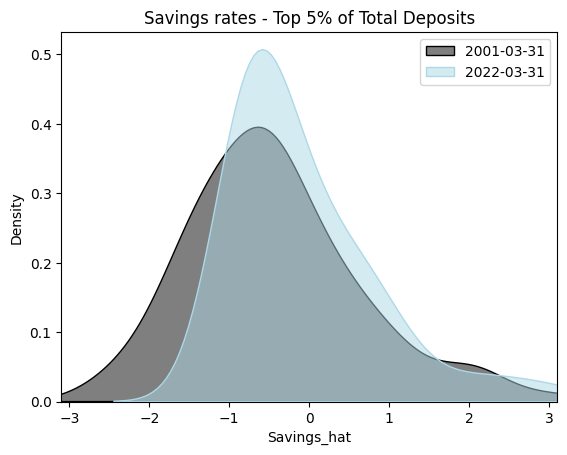

In [37]:
# plot the kernel distribution of the deposit rates for the above dates:
sns.kdeplot(df2_top[df_top['Date']=='2001-03-31']['Savings_hat'], label='2001-03-31', color='black', fill=True, alpha=0.5)
sns.kdeplot(df2_top[df_top['Date']=='2022-03-31']['Savings_hat'], label='2022-03-31', color='lightblue', fill=True, alpha=0.5)
plt.xlim(-3.1, 3.1)
plt.legend()
plt.title('Savings rates - Top 5% of Total Deposits')
plt.show()

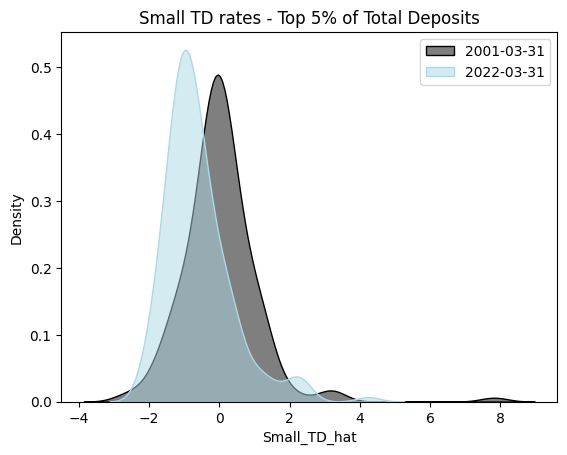

In [38]:
# plot the kernel distribution of the deposit rates for the above dates:
sns.kdeplot(df3_top[df3_top['Date']=='2001-03-31']['Small_TD_hat'], label='2001-03-31', color='black', fill=True, alpha=0.5)
sns.kdeplot(df3_top[df3_top['Date']=='2022-03-31']['Small_TD_hat'], label='2022-03-31', color='lightblue', fill=True, alpha=0.5)
#plt.xlim(-0.02, 0.02)
plt.legend()
plt.title('Small TD rates - Top 5% of Total Deposits')
plt.show()

##### Tracking deposits

In [75]:
df = main[[ 'IDRSSD', 'Date', 'Financial Institution Name',                           # Dates and IDS 
            'Total Deposit', 'Deposit Share', 
            'Deposit Variation', 'Deposit Share Variation',                           # Bank specific quantity variables
            'Deposit Rate', 'R_hat',                                                  # Bank specific rate variable
            'Savings Rate',                                                           # Deposit type rates
            'Aggregate Deposits', 'Aggregate Deposits Variation',                     # Aggregate quantity variables 
            'FEDFUNDS', 'Weighted Deposit Rate'                                       # Aggregate rate variables
            ]]

In [76]:
# Drop the NaN values in the 'variation' variables:
df = df.dropna(subset = ['Deposit Variation', 'Aggregate Deposits Variation'])

# Compute the Reallocation Term: A = D_t * (s_{it} - s_{it-1})
df['Reallocation Term'] = df['Aggregate Deposits'] * df['Deposit Share Variation'] 

# Compute the Aggregate Growth Term: B = s_{it-1} * (D_t - D_{t-1})
df['Agg. Growth Term'] = df['Deposit Share'].shift(1) * df['Aggregate Deposits Variation'] 

# Drop the NaN values in the 'variation' variables:
df = df.dropna(subset = ['Reallocation Term', 'Agg. Growth Term'])

# compute the 'Growth Rate' variable by subtracting log of 'Total Deposit' in t-1 from log of 'Total Deposit' in t:
df['Growth Rate'] = np.log(df['Total Deposit']).diff()

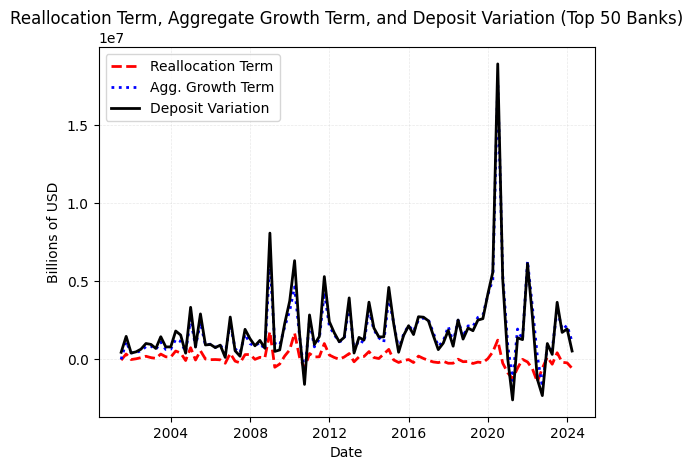

In [77]:
# do the same plot as above for the top 50 banks in 'Total Deposit' in March 2019:
how_many = 50
top_how_many = df[df['Date'] == '2019-03-31'].nlargest(how_many, 'Total Deposit')['IDRSSD']

# make the same plot as above considering only IDRSSD in top_50:
sns.lineplot(data = df[df['IDRSSD'].isin(top_how_many)], x = 'Date', y = 'Reallocation Term', 
             label = 'Reallocation Term', color = 'red', linewidth = 2, errorbar=None, linestyle='--')
sns.lineplot(data = df[df['IDRSSD'].isin(top_how_many)], x = 'Date', y = 'Agg. Growth Term',
                label = 'Agg. Growth Term', color = 'blue', linewidth = 2, linestyle=':', errorbar=None)
sns.lineplot(data = df[df['IDRSSD'].isin(top_how_many)], x = 'Date', y = 'Deposit Variation',
                label = 'Deposit Variation', color = 'black', linewidth = 2, errorbar=None, linestyle='-')
plt.xlabel('Date')
plt.ylabel('Billions of USD')
plt.title(f'Reallocation Term, Aggregate Growth Term, and Deposit Variation (Top {how_many} Banks)')
plt.grid(color = 'lightgray', linestyle = '--', linewidth = 0.5, alpha = 0.5)
plt.legend(loc='upper left')
plt.show()

In [78]:
# print the dates for which all top_50 banks show up in the dataset:
dates_top = df[df['IDRSSD'].isin(top_how_many)].groupby('Date')['IDRSSD'].nunique()

#dates_top[dates_top == how_many].index

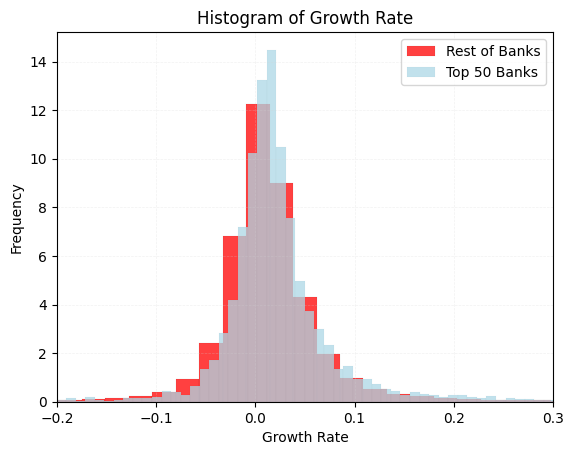

In [79]:
# plot a histogram of the 'Growth Rate' variable:
sns.histplot(df[(~df['IDRSSD'].isin(top_how_many)) 
                #& (df['Date'].isin(dates_top[dates_top == how_many].index))
                ]['Growth Rate'], 
             color = 'red', stat='density', bins = 1000, edgecolor = 'black')
sns.histplot(df[(df['IDRSSD'].isin(top_how_many)) 
                #& (df['Date'].isin(dates_top[dates_top == how_many].index))
                ]['Growth Rate'], 
             color = 'lightblue', stat='density', bins = 1000, edgecolor = 'black')
plt.xlabel('Growth Rate')
plt.ylabel('Frequency')
plt.title('Histogram of Growth Rate')
plt.grid(color = 'lightgray', linestyle = '--', linewidth = 0.5, alpha = 0.3)
plt.xlim(-0.2, 0.3)
plt.legend(['Rest of Banks', f'Top {how_many} Banks'])
plt.show()

In [80]:
# Create a 'Time' column that attributes a number to each date:
df['Time'] = df.groupby('Date').ngroup()

# Regress log(Aggretate Deposits) on 'Time'. Save the de-trended series in 'Detrended Agg. Deposits':
df['Detrended Agg. Deposits'] = sm.OLS(np.log(df['Aggregate Deposits']), sm.add_constant(df['Time'])).fit().resid

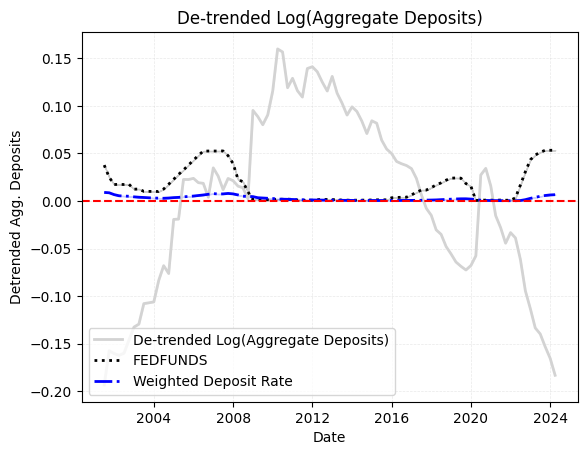

In [81]:
# Plot the de-trended series:
sns.lineplot(data = df, x = 'Date', y = 'Detrended Agg. Deposits', linewidth = 2, 
             color = 'lightgrey', label = 'De-trended Log(Aggregate Deposits)')
# add the FEDFUNDS rate:
sns.lineplot(data = df, x = 'Date', y = 'FEDFUNDS', linewidth = 2, 
             color = 'black', label = 'FEDFUNDS', linestyle=':')
# add the weighted deposit rate:
sns.lineplot(data = df, x = 'Date', y = 'Weighted Deposit Rate', linewidth = 2, 
             color = 'blue', linestyle='-.', label = 'Weighted Deposit Rate')
# add a horizontal line at 0:
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Date')
plt.title('De-trended Log(Aggregate Deposits)')
plt.grid(color = 'lightgray', linestyle = '--', linewidth = 0.5, alpha = 0.5)
plt.legend(loc='lower left')
plt.show()

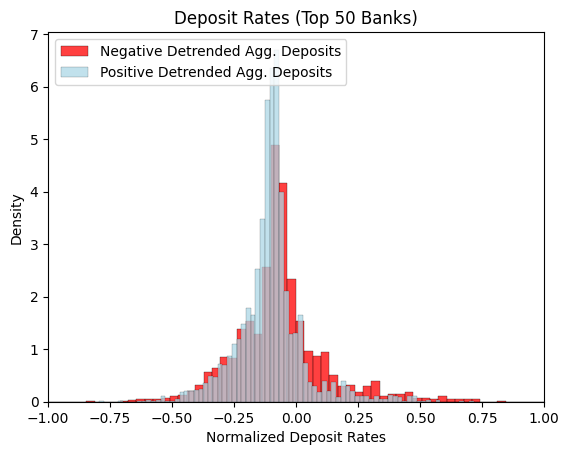

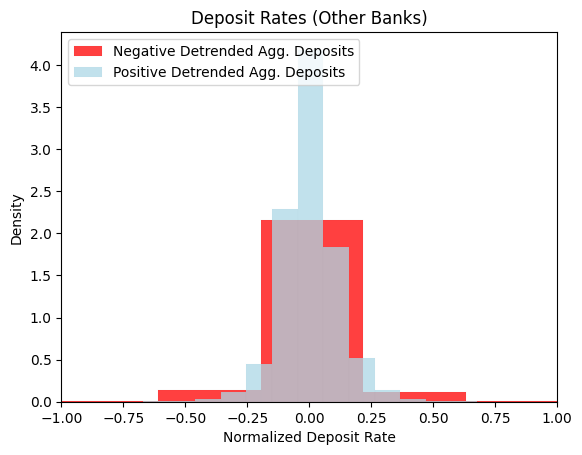

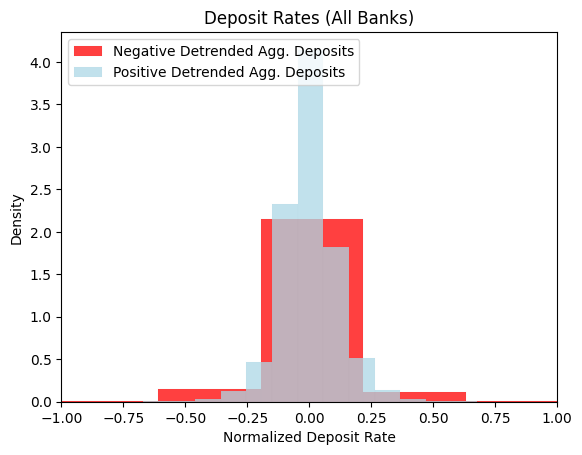

In [82]:
# for all the moments where the 'Detrended Agg. Deposits' is below 0, plot make a histogram of the 'Deposit Variation':
sns.histplot(df[(df['Detrended Agg. Deposits'] < 0) &
                (df['IDRSSD'].isin(top_how_many))
                #& (df['Date'].isin(dates_top[dates_top == how_many].index))
                ]['R_hat']*100, bins = 150, color = 'red', stat = 'density')
sns.histplot(df[(df['Detrended Agg. Deposits'] > 0) &
                (df['IDRSSD'].isin(top_how_many))
                #& (df['Date'].isin(dates_top[dates_top == how_many].index))
                ]['R_hat']*100, bins = 150, color = 'lightblue', stat = 'density')
plt.xlabel('Normalized Deposit Rates')
plt.ylabel('Density')
plt.title(f'Deposit Rates (Top {how_many} Banks)')
plt.xlim(-1, 1)
plt.legend(['Negative Detrended Agg. Deposits', 'Positive Detrended Agg. Deposits'], loc='upper left')
plt.show()

# for all the moments where the 'Detrended Agg. Deposits' is below 0, plot make a histogram of the 'Deposit Variation':
sns.histplot(df[(df['Detrended Agg. Deposits'] < 0) &
                (~df['IDRSSD'].isin(top_how_many))]['R_hat']*100, bins = 2000, color = 'red', stat = 'density')
sns.histplot(df[(df['Detrended Agg. Deposits'] > 0) &
                (~df['IDRSSD'].isin(top_how_many))]['R_hat']*100, bins = 100, color = 'lightblue', stat = 'density')
plt.xlabel('Normalized Deposit Rate')
plt.ylabel('Density')
plt.title(f'Deposit Rates (Other Banks)')
plt.xlim(-1, 1)
plt.legend(['Negative Detrended Agg. Deposits', 'Positive Detrended Agg. Deposits'], loc='upper left')
plt.show()

# for all the moments where the 'Detrended Agg. Deposits' is below 0, plot make a histogram of the 'Deposit Variation':
sns.histplot(df[(df['Detrended Agg. Deposits'] < 0)]['R_hat']*100, bins = 2000, color = 'red', stat = 'density')
sns.histplot(df[(df['Detrended Agg. Deposits'] > 0)]['R_hat']*100, bins = 100, color = 'lightblue', stat = 'density')
plt.xlabel('Normalized Deposit Rate')
plt.ylabel('Density')
plt.title(f'Deposit Rates (All Banks)')
plt.xlim(-1, 1)
plt.legend(['Negative Detrended Agg. Deposits', 'Positive Detrended Agg. Deposits'], loc='upper left')
plt.show()

In [83]:
# create a variable named 'FF Hike' that is 1 if the FEDFUNDS rate increased, 0 otherwise:
df['FF Hike'] = df['FEDFUNDS'].diff().apply(lambda x: 1 if x >= 0 else 0)

# create a variable named 'FF Cut' that is 1 if the FEDFUNDS rate decreased, 0 otherwise:
df['FF Cut'] = df['FEDFUNDS'].diff().apply(lambda x: 1 if x < 0 else 0)

# compute the mean of 'FEDFUNDS' accross all dates:
mean_fedfunds = df['FEDFUNDS'].mean()

# create a variable named 'FF High' that is 1 if the FEDFUNDS rate is above the mean, 0 otherwise:
df['FF High'] = df['FEDFUNDS'].apply(lambda x: 1 if x > mean_fedfunds else 0)

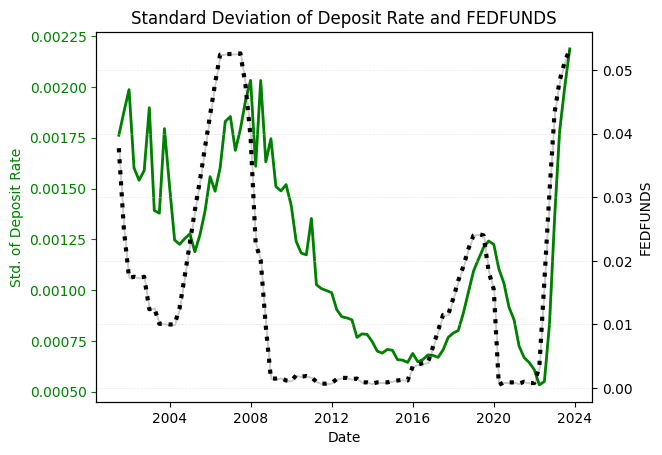

In [84]:
# make a time-series of the standard deviation of the 'Deposit Rate' variable and plot it:
df['Std. Deposit Rate'] = df.groupby('Date')['Deposit Rate'].transform('std')

# plot the time series of the standard deviation of the 'Deposit Rate' variable.
sns.lineplot(data = df[df['Date']<'2023-12-31'], x = 'Date', y = 'Std. Deposit Rate', linewidth = 2, color = 'green')
# paint the left y-axis in grey, as well as the ticks and labels:
plt.yticks(color = 'green')
plt.tick_params(axis='y', colors='green')
# can you also paint the left y-label in green:
plt.ylabel('Std. of Deposit Rate', color = 'green')

# In the right y-axis, plot the FEDFUNDS rate:
ax2 = plt.twinx()
sns.lineplot(data = df[df['Date']<'2023-12-31'], x = 'Date', y = 'FEDFUNDS', linewidth = 3, color = 'black', linestyle=':', ax=ax2)
# paint the right y-axis in blue, as well as the ticks and labels:
ax2.yaxis.label.set_color('black')
ax2.tick_params(axis='y', colors='black')

plt.xlabel('Date')
plt.title('Standard Deviation of Deposit Rate and FEDFUNDS')
plt.grid(color = 'lightgray', linestyle = '--', linewidth = 0.5, alpha = 0.5)
plt.show()


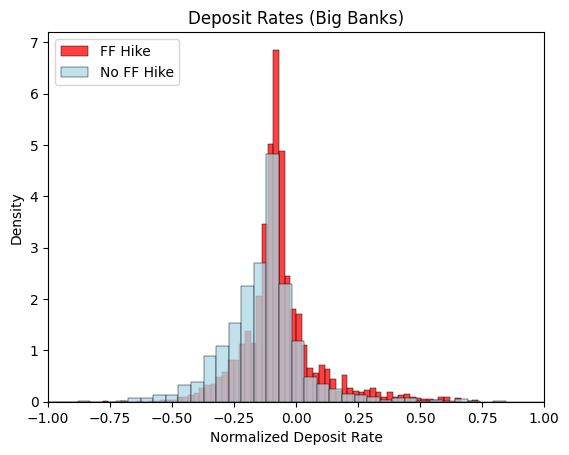

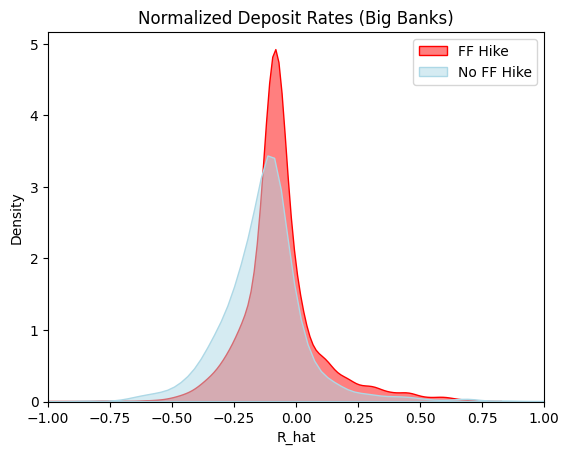

In [85]:
# plot the histogram of 'R_hat' for moments where the 'Detrended Agg. Deposits' is below/above 0, and when 'FF Hike' is 1:
sns.histplot(df[(df['FF Hike'] == 1) & 
                (df['IDRSSD'].isin(top_how_many))
                #& (df['Date'].isin(dates_top[dates_top == how_many].index))
                ]['R_hat']*100, bins = 100, color = 'red', stat = 'density', kde=False)
sns.histplot(df[(df['FF Hike'] == 0) &
                (df['IDRSSD'].isin(top_how_many))
                #& (df['Date'].isin(dates_top[dates_top == how_many].index))
                ]['R_hat']*100, bins = 100, color = 'lightblue', stat = 'density', kde=False)
plt.xlabel('Normalized Deposit Rate')
plt.ylabel('Density')
plt.title(f'Deposit Rates (Big Banks)')
plt.xlim(-1, 1)
plt.legend(['FF Hike', 'No FF Hike'], loc='upper left')
plt.show()

# plot only the kernel density of 'R_hat' for moments where the 'Detrended Agg. Deposits' is below/above 0, and when 'FF Hike' is 1:
sns.kdeplot(df[(df['FF Hike'] == 1) & 
                (df['IDRSSD'].isin(top_how_many))
                #& (df['Date'].isin(dates_top[dates_top == how_many].index))
                ]['R_hat']*100, color = 'red', fill=True, alpha=0.5)
sns.kdeplot(df[(df['FF Hike'] == 0) &
                (df['IDRSSD'].isin(top_how_many))
                #& (df['Date'].isin(dates_top[dates_top == how_many].index))
                ]['R_hat']*100, color = 'lightblue', fill=True, alpha=0.5)
plt.xlim(-1, 1)
plt.legend(['FF Hike', 'No FF Hike'])
plt.title('Normalized Deposit Rates (Big Banks)')
plt.show()

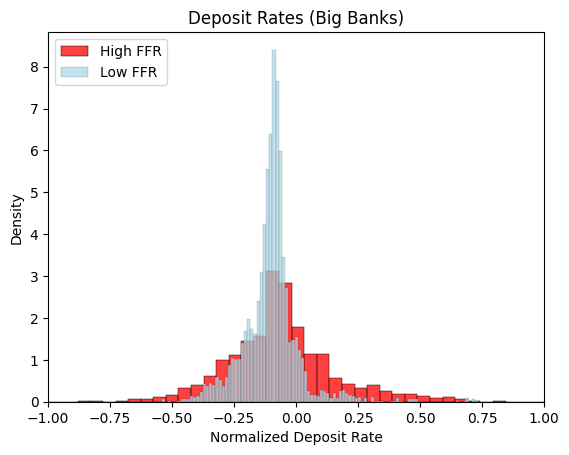

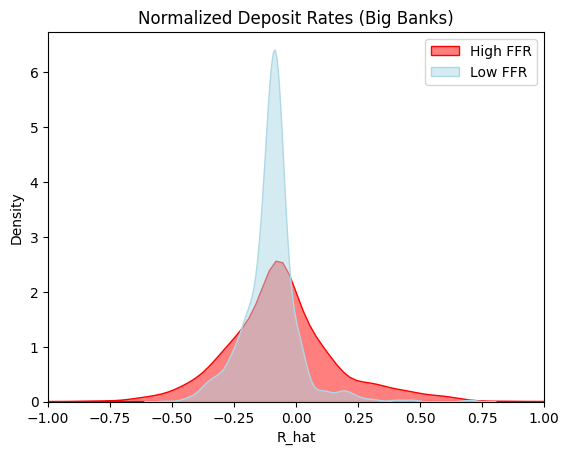

In [86]:
# plot the histogram of 'R_hat' for moments where the 'Detrended Agg. Deposits' is below/above 0, and when 'FF Hike' is 1:
sns.histplot(df[(df['FF High'] == 1) & 
                (df['IDRSSD'].isin(top_how_many))
                #& (df['Date'].isin(dates_top[dates_top == how_many].index))
                ]['R_hat']*100, bins = 100, color = 'red', stat = 'density', kde=False)
sns.histplot(df[(df['FF High'] == 0) &
                (df['IDRSSD'].isin(top_how_many))
                #& (df['Date'].isin(dates_top[dates_top == how_many].index))
                ]['R_hat']*100, bins = 100, color = 'lightblue', stat = 'density', kde=False)
plt.xlabel('Normalized Deposit Rate')
plt.ylabel('Density')
plt.title(f'Deposit Rates (Big Banks)')
plt.xlim(-1, 1)
plt.legend(['High FFR', 'Low FFR'], loc='upper left')
plt.show()

# plot only the kernel density of 'R_hat' for moments where the 'Detrended Agg. Deposits' is below/above 0, and when 'FF Hike' is 1:
sns.kdeplot(df[(df['FF High'] == 1) & 
                (df['IDRSSD'].isin(top_how_many))
                #& (df['Date'].isin(dates_top[dates_top == how_many].index))
                ]['R_hat']*100, color = 'red', fill=True, alpha=0.5)
sns.kdeplot(df[(df['FF High'] == 0) &
                (df['IDRSSD'].isin(top_how_many))
                #& (df['Date'].isin(dates_top[dates_top == how_many].index))
                ]['R_hat']*100, color = 'lightblue', fill=True, alpha=0.5)
plt.xlim(-1, 1)
plt.legend(['High FFR', 'Low FFR'])
plt.title('Normalized Deposit Rates (Big Banks)')
plt.show()

In [87]:
# make a test on the variance of 'R_hat' when 'FF Hike' is 1 or 0:
from scipy.stats import levene

stat, pval = levene(df[(df['FF Hike'] == 1) &
                (df['IDRSSD'].isin(top_how_many))
                #& (df['Date'].isin(dates_top[dates_top == how_many].index))
                ]['R_hat'], 
          df[(df['FF Hike'] == 0) &
                (df['IDRSSD'].isin(top_how_many))
                #& (df['Date'].isin(dates_top[dates_top == how_many].index))
                ]['R_hat'])

if pval<0.05:
    print('The p-value of the Levene test is:', pval)
    print('The null of equal variance is rejected.')
    print('The variance of the Deposit Rate is different when the FEDFUNDS rate is hiked.')

stat, pval = levene(df[(df['FF High'] == 1) &
            (df['IDRSSD'].isin(top_how_many))
            #& (df['Date'].isin(dates_top[dates_top == how_many].index))
            ]['R_hat'], 
      df[(df['FF High'] == 0) &
            (df['IDRSSD'].isin(top_how_many))
            #& (df['Date'].isin(dates_top[dates_top == how_many].index))
            ]['R_hat'])

if pval<0.05:
    print('The p-value of the Levene test is:', pval)
    print('The null of equal variance is rejected.')
    print('The variance of the Deposit Rate is different when the FEDFUNDS rate is above avg.')


The p-value of the Levene test is: 7.391350556098863e-05
The null of equal variance is rejected.
The variance of the Deposit Rate is different when the FEDFUNDS rate is hiked.
The p-value of the Levene test is: 9.234257764676214e-99
The null of equal variance is rejected.
The variance of the Deposit Rate is different when the FEDFUNDS rate is above avg.


##### How about repos? 

In [56]:
# Expenditure
main['Income Repo']         = main['RIAD4020']
main['Expenditure Repo']    = main['RIAD4180']

# Quantities
main['Repo Loans']          = main['RCFD3365']
main['Repo Debt']           = main['RCFD3353']

# Group by 'ID' and compute the difference in 'Deposit_Expenditure' to get the actual expenditure per period
main['Actual Expenditure Repo'] = main.groupby(['IDRSSD', 'Year'])['Expenditure Repo'].diff().fillna(main['Expenditure Repo'])
main['Actual Income Repo'] = main.groupby(['IDRSSD', 'Year'])['Expenditure Repo'].diff().fillna(main['Income Repo'])

C:\Users\angel\AppData\Local\Temp\ipykernel_22500\292608507.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main['Income Repo']         = main['RIAD4020']
C:\Users\angel\AppData\Local\Temp\ipykernel_22500\292608507.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main['Expenditure Repo']    = main['RIAD4180']
C:\Users\angel\AppData\Local\Temp\ipykernel_22500\292608507.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

In [57]:
df = main[[ 'IDRSSD', 'Date', 'Financial Institution Name',                           # Dates and IDS 
            'Total Deposit', 'Deposit Share',                                         # Bank specific quantities
            'Repo Loans', 'Repo Debt',                                                # Bank specific repo quantities
            'Actual Expenditure Repo', 'Actual Income Repo',                          # Bank specific repo income/expenditure 
            'Deposit Rate', 'R_hat',                                                  # Bank specific rate variable
            'FEDFUNDS', 'Weighted Deposit Rate'                                       # Aggregate rate variables
            ]]

In [58]:
# keep only 'Repo Loans' and 'Repo Debt' > 0:
df = df[(df['Repo Debt']>0) & (df['Repo Loans']>0)]

# Compute 'Repo Loan Rate' and 'Repo Debt Rate':
df['Total Repo'] = df['Repo Loans'] - df['Repo Debt']

In [59]:
# Compute the Repo Loan Rate:
df['Repo Loan Rate'] = df['Actual Income Repo'] / df['Repo Loans']

# Compute the Repo Debt Rate:
df['Repo Debt Rate'] = df['Actual Expenditure Repo'] / df['Repo Debt']

In [60]:
# For each date and bank, compute the normalized 'Repo Loan Rate' and 'Repo Debt Rate':
df['Repo Loan Rate Norm'] = df.groupby('Date')['Repo Loan Rate'].transform(lambda x: (x - x.mean())/x.std())
df['Repo Debt Rate Norm'] = df.groupby('Date')['Repo Debt Rate'].transform(lambda x: (x - x.mean())/x.std())

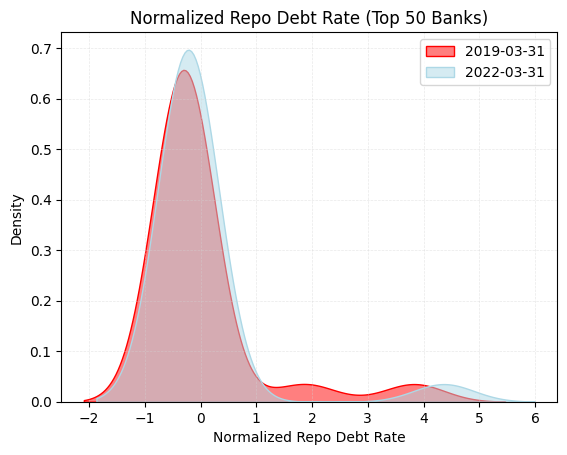

In [61]:
# plot the 'Repo Debt Rate Norm' distribution for the top 50 banks in 'Total Deposit' in March 2019:
sns.kdeplot(df[df['Date'] == '2019-03-31']['Repo Debt Rate Norm'], 
            color = 'red', fill = True, alpha = 0.5)
sns.kdeplot(df[df['Date'] == '2022-03-31']['Repo Debt Rate Norm'], 
            color = 'lightblue', fill = True, alpha = 0.5)
plt.xlabel('Normalized Repo Debt Rate')
plt.ylabel('Density')
plt.title('Normalized Repo Debt Rate (Top 50 Banks)')
plt.grid(color = 'lightgray', linestyle = '--', linewidth = 0.5, alpha = 0.5)
plt.legend(['2019-03-31', '2022-03-31'])
plt.show()

In [62]:
df['Total Repo'].describe()

count    3.281000e+03
mean     1.444862e+06
std      2.135237e+07
min     -1.478189e+08
25%     -2.006209e+06
50%     -3.406280e+05
75%      2.333700e+04
max      2.444250e+08
Name: Total Repo, dtype: float64

In [63]:
# describe the banks below median in 'Total Repo':
df[df['Total Repo'] < df['Total Repo'].median()]['Deposit Rate'].describe()

count    1640.000000
mean        0.003632
std         0.003013
min        -0.008233
25%         0.000961
50%         0.003048
75%         0.005621
max         0.019163
Name: Deposit Rate, dtype: float64

In [64]:
df[df['Total Repo'] > df['Total Repo'].median()]['Deposit Rate'].describe()

count    1640.000000
mean        0.003410
std         0.003559
min        -0.025048
25%         0.000725
50%         0.002158
75%         0.005299
max         0.048207
Name: Deposit Rate, dtype: float64

##### Serious decomposition? 

In [65]:
df = main[[ 'IDRSSD', 'Date', 'Financial Institution Name',                           # Dates and IDS 
            'Total Deposit', 'Deposit Variation',                                     # Bank specific deposit variables
            'Deposit Share', 'Deposit Share Variation',                               # Bank specific share variables
            'Aggregate Deposits', 'Aggregate Deposits Variation',                     # Aggregate deposit variables 
            ]]

In [66]:
# Create a column named 'Entry Date' which is the 'Date' of the first observation of each bank. Use .iloc:
df['Entry Date'] = df.groupby('IDRSSD')['Date'].transform('first')
df['Exit Date'] = df.groupby('IDRSSD')['Date'].transform('last')

C:\Users\angel\AppData\Local\Temp\ipykernel_22500\2609875640.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Entry Date'] = df.groupby('IDRSSD')['Date'].transform('first')
C:\Users\angel\AppData\Local\Temp\ipykernel_22500\2609875640.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Exit Date'] = df.groupby('IDRSSD')['Date'].transform('last')


In [67]:
df

,IDRSSD,Date,Financial Institution Name,Total Deposit,Deposit Variation,Deposit Share,Deposit Share Variation,Aggregate Deposits,Aggregate Deposits Variation,Entry Date,Exit Date
0,37,2001-03-31,BANK OF HANCOCK COUNTY,45299.0,NaN,0.000032,NaN,1.395340e+09,NaN,2001-03-31,2024-03-31
162954,37,2001-06-30,BANK OF HANCOCK COUNTY,44748.0,-551.0,0.000031,-1.265290e-06,1.434268e+09,38927576.0,2001-03-31,2024-03-31
320110,37,2001-09-30,BANK OF HANCOCK COUNTY,47234.0,2486.0,0.000031,-1.676194e-07,1.522127e+09,87859234.0,2001-03-31,2024-03-31
476165,37,2001-12-31,BANK OF HANCOCK COUNTY,49528.0,2294.0,0.000032,8.430000e-07,1.553840e+09,31713270.0,2001-03-31,2024-03-31
8857,37,2002-03-31,BANK OF HANCOCK COUNTY,49429.0,-99.0,0.000031,-7.455466e-07,1.587874e+09,34034469.0,2001-03-31,2024-03-31
...,...,...,...,...,...,...,...,...,...,...,...
157893,2998576,2023-03-31,CELTIC BANK CORPORATION,1530713.0,230003.0,0.000130,1.908558e-05,1.181916e+10,40094690.0,2001-06-30,2024-03-31
319672,2998576,2023-06-30,CELTIC BANK CORPORATION,1775344.0,244631.0,0.000148,1.811982e-05,1.202555e+10,206392916.0,2001-06-30,2024-03-31
475725,2998576,2023-09-30,CELTIC BANK CORPORATION,1816265.0,40921.0,0.000150,1.886570e-06,1.214751e+10,121951914.0,2001-06-30,2024-03-31
630395,2998576,2023-12-31,CELTIC BANK CORPORATION,1936090.0,119825.0,0.000158,8.068540e-06,1.228592e+10,138415582.0,2001-06-30,2024-03-31


In [68]:
# Create a log difference of 'Total Deposit':
df['Log Diff. Total Deposit'] = np.log(df['Total Deposit']).diff()

C:\Users\angel\AppData\Local\Temp\ipykernel_22500\2510872740.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Log Diff. Total Deposit'] = np.log(df['Total Deposit']).diff()


In [69]:
df

,IDRSSD,Date,Financial Institution Name,Total Deposit,Deposit Variation,Deposit Share,Deposit Share Variation,Aggregate Deposits,Aggregate Deposits Variation,Entry Date,Exit Date,Log Diff. Total Deposit
0,37,2001-03-31,BANK OF HANCOCK COUNTY,45299.0,NaN,0.000032,NaN,1.395340e+09,NaN,2001-03-31,2024-03-31,NaN
162954,37,2001-06-30,BANK OF HANCOCK COUNTY,44748.0,-551.0,0.000031,-1.265290e-06,1.434268e+09,38927576.0,2001-03-31,2024-03-31,-0.012238
320110,37,2001-09-30,BANK OF HANCOCK COUNTY,47234.0,2486.0,0.000031,-1.676194e-07,1.522127e+09,87859234.0,2001-03-31,2024-03-31,0.054067
476165,37,2001-12-31,BANK OF HANCOCK COUNTY,49528.0,2294.0,0.000032,8.430000e-07,1.553840e+09,31713270.0,2001-03-31,2024-03-31,0.047424
8857,37,2002-03-31,BANK OF HANCOCK COUNTY,49429.0,-99.0,0.000031,-7.455466e-07,1.587874e+09,34034469.0,2001-03-31,2024-03-31,-0.002001
...,...,...,...,...,...,...,...,...,...,...,...,...
157893,2998576,2023-03-31,CELTIC BANK CORPORATION,1530713.0,230003.0,0.000130,1.908558e-05,1.181916e+10,40094690.0,2001-06-30,2024-03-31,0.162823
319672,2998576,2023-06-30,CELTIC BANK CORPORATION,1775344.0,244631.0,0.000148,1.811982e-05,1.202555e+10,206392916.0,2001-06-30,2024-03-31,0.148261
475725,2998576,2023-09-30,CELTIC BANK CORPORATION,1816265.0,40921.0,0.000150,1.886570e-06,1.214751e+10,121951914.0,2001-06-30,2024-03-31,0.022788
630395,2998576,2023-12-31,CELTIC BANK CORPORATION,1936090.0,119825.0,0.000158,8.068540e-06,1.228592e+10,138415582.0,2001-06-30,2024-03-31,0.063888


##### Maturity of Deposits

In [88]:
main['Small TD Maturity'] = np.where(main['Date'] < '2017-01-01', 0.25*main['RCONA579']+15/12*main['RCONA580']+2*main['RCONA581']+3*main['RCONA582'],
                               0.25*main['RCONHK07']+15/12*main['RCONHK08']+2*main['RCONHK09']+5*main['RCONHK10'])
main['Large TD Maturity'] = np.where(main['Date'] < '2017-01-01', 0.25*main['RCONA584']+15/12*main['RCONA585']+2*main['RCONA586']+3*main['RCONA587'],
                               0.25*main['RCONHK12']+15/12*main['RCONHK13']+2*main['RCONHK14']+5*main['RCONHK15'])

C:\Users\angel\AppData\Local\Temp\ipykernel_22500\2014289685.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main['Small TD Maturity'] = np.where(main['Date'] < '2017-01-01', 0.25*main['RCONA579']+15/12*main['RCONA580']+2*main['RCONA581']+3*main['RCONA582'],
C:\Users\angel\AppData\Local\Temp\ipykernel_22500\2014289685.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main['Large TD Maturity'] = np.where(main['Date'] < '2017-01-01', 0.25*main['RCONA584']+15/12*main['RCONA585']+2*main['RCONA586']+3*main

In [89]:
main['Deposit Maturity'] = (0*(main['Transaction Accounts'] + main['Savings Accounts'])+ 5*main['RCON3200'] + main['Small TD Maturity'] + main['Large TD Maturity'])/(main['Transaction Accounts'] + main['Savings Accounts'] + main['Small TD'] + main['Large TD'])

# MISSING THE "(...) and Fed funds purchased"                         

C:\Users\angel\AppData\Local\Temp\ipykernel_22500\3099153765.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main['Deposit Maturity'] = (0*(main['Transaction Accounts'] + main['Savings Accounts'])+ 5*main['RCON3200'] + main['Small TD Maturity'] + main['Large TD Maturity'])/(main['Transaction Accounts'] + main['Savings Accounts'] + main['Small TD'] + main['Large TD'])


In [90]:
df = main[['IDRSSD', 'Date', 'Total Deposit', 'Deposit Rate', 'Deposit Maturity', 'FEDFUNDS', 'Weighted Deposit Rate']]

In [91]:
# trim at the 1% and 99% quantiles in 'Deposit Matutiry':
df = df[(df['Deposit Maturity'] >= df['Deposit Maturity'].quantile(0.01)) & (df['Deposit Maturity'] <= df['Deposit Maturity'].quantile(0.99))]

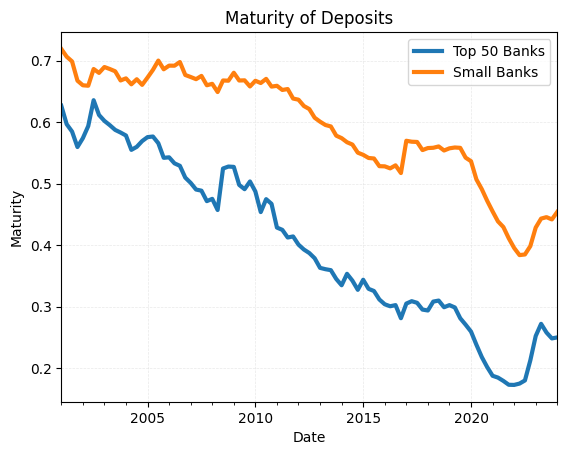

In [ ]:
# Make the same plot as above, but for the top 50 banks in 'Total Deposit' in March 2019:
top_50 = df[df['Date'] == '2019-03-31'].nlargest(50, 'Total Deposit')['IDRSSD']

# make the same plot as above considering only IDRSSD in top_50:
df[df['IDRSSD'].isin(top_50)].groupby('Date')['Deposit Maturity'].mean().plot(linewidth=3)
# plot now considering the IDRSSD that are NOT in top_50:
df[~df['IDRSSD'].isin(top_50)].groupby('Date')['Deposit Maturity'].mean().plot(linewidth=3)
plt.xlabel('Date')
plt.ylabel('Maturity')
plt.title('Maturity of Deposits')
plt.legend(['Top 50 Banks', 'Small Banks'])
plt.grid(color = 'lightgray', linestyle = '--', linewidth = 0.5, alpha = 0.5)
plt.show()